In [4]:
import os

In [4]:
import arcpy

In [1]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify

In [2]:
ExtensionName = 'Spatial'
if arcpy.CheckExtension(ExtensionName) == "Available":
        arcpy.CheckOutExtension(ExtensionName)

In [3]:
arcpy.env.workspace = r'T:\Models\StoryMap\UrbanSim\UrbanSim.gdb'
arcpy.env.overwriteOutput = True

In [6]:
path = r'T:\Trans Projects\Model Development\UrbanSim_LandUse\Output\Simulation_47_Final_RTP'

In [9]:
yrbuilt = 2021

In [10]:
arcpy.FeatureToPoint_management(in_features=os.path.join(path, 'newDevAnn'+ str(yrbuilt) +'.shp'), 
                                out_feature_class="newDevCentroid", point_location="INSIDE")

<Result 'T:\\Models\\StoryMap\\UrbanSim\\UrbanSim.gdb\\newDevCentroid'>

In [13]:
arcpy.gp.KernelDensity_sa("newDevCentroid", "nnsqft", os.path.join(path,"KernelD_nnsqft_" + str(yrbuilt) + ".tif"), "100", 
                          "", "SQUARE_KILOMETERS", "DENSITIES", "GEODESIC")

<geoprocessing server result object at 0x1875e07abd0>

In [6]:
import rasterio

In [7]:
from rasterio.plot import show

In [17]:
MPObd = gpd.read_file("V:/Data/Transportation/MPO_Bound.shp")

In [20]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [21]:
dst_crs = 'EPSG:3857'

In [22]:
with rasterio.open(os.path.join(path,"KernelD_nnsqft_" + str(yrbuilt) + ".tif")) as src:
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        with rasterio.open(os.path.join(path,"KernelD_nnsqft_" + str(yrbuilt) + "_3857.tif"), 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [49]:
dataset = rasterio.open(os.path.join(path,"KernelD_nnsqft_" + str(yrbuilt) + ".tif"))

In [51]:
dataset

<open DatasetReader name='T:\Trans Projects\Model Development\UrbanSim_LandUse\Output\Simulation_47_Final_RTP\KernelD_nnsqft_2021.tif' mode='r'>

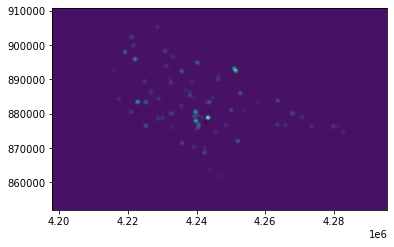

<AxesSubplot:>

In [50]:
show(dataset)

In [25]:
import fiona

In [26]:
with fiona.open("V:/Data/Transportation/MPO_Bound.shp", "r") as vectorfile:
        shapes = [feature["geometry"] for feature in vectorfile]

In [27]:
from rasterio.mask import mask

In [28]:
out_image, out_transform = mask(dataset=dataset, shapes=shapes, crop=True)

In [30]:
out_meta = dataset.meta.copy()

In [31]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [62]:
file = os.path.join(path,"KernelD_nnsqft_" + str(yrbuilt) + "_clipped.tif")

In [33]:
with rasterio.open(file, "w", **out_meta) as dest:
        dest.write(out_image)

In [65]:
raster = rasterio.open(file)

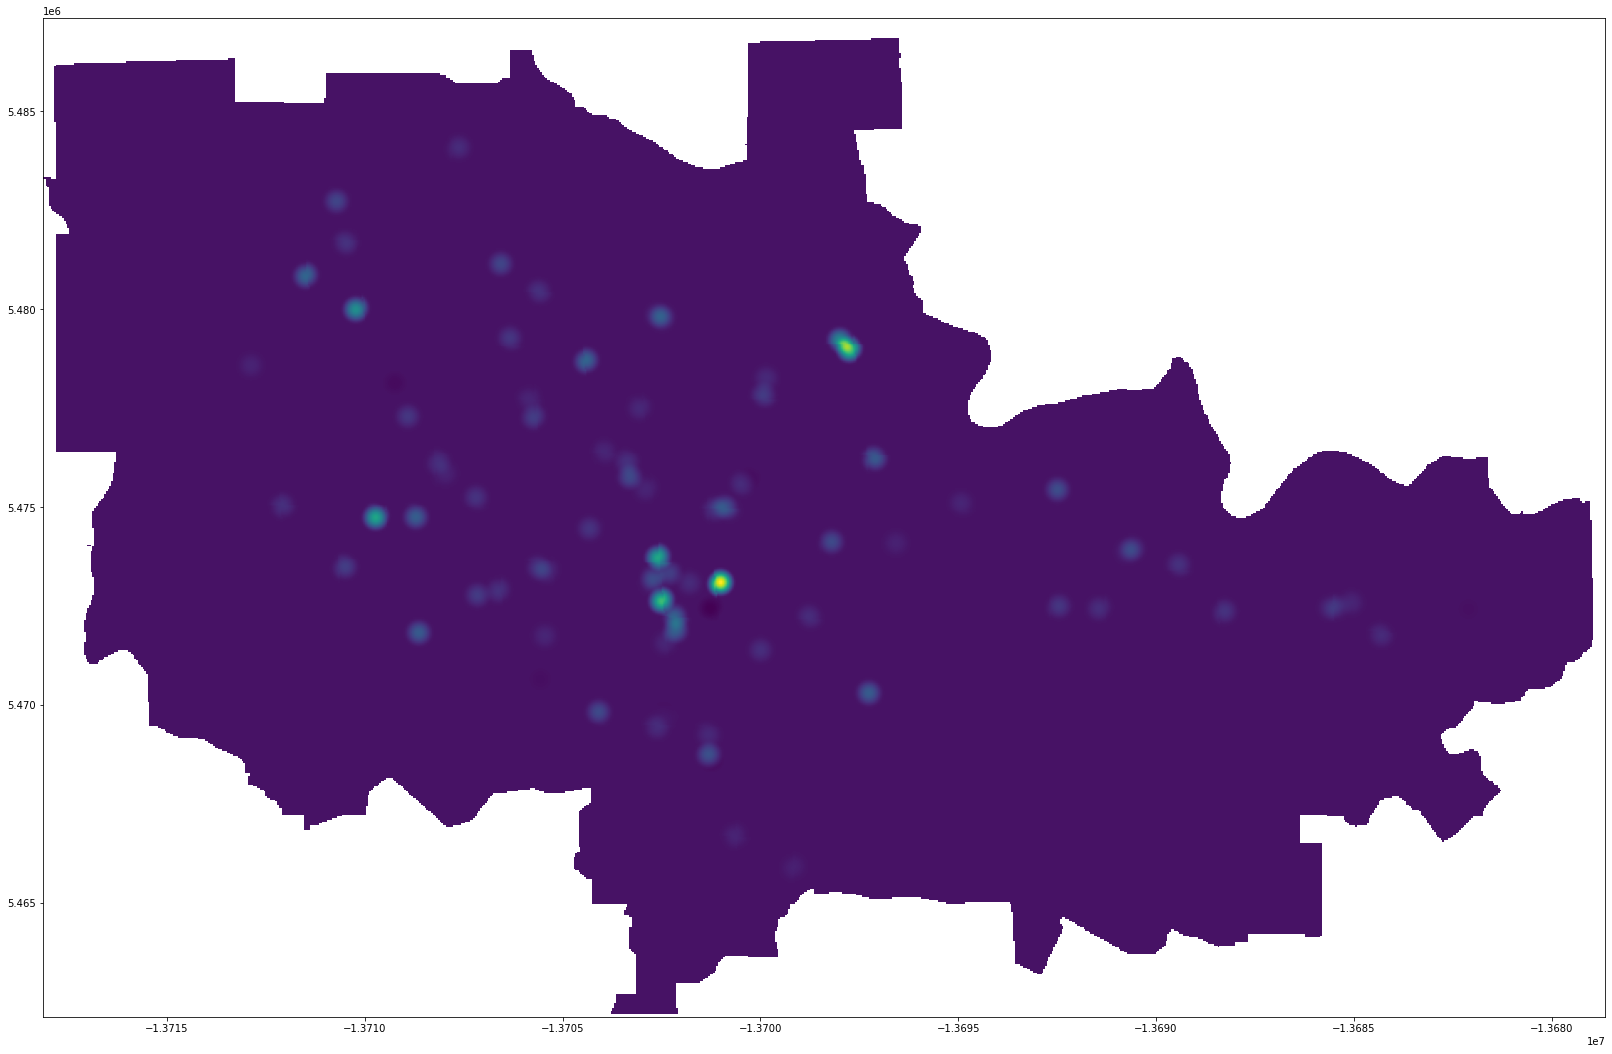

<AxesSubplot:>

In [64]:
fig, ax = plt.subplots(1, figsize=(28, 24))
show(raster)

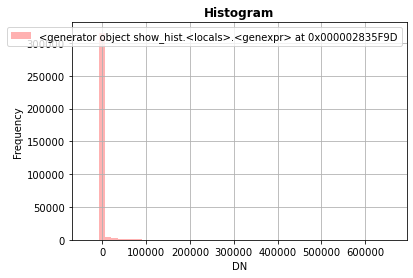

In [66]:
from rasterio.plot import show_hist

show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram")

In [70]:
src = rasterio.open(file, mode="r+")

In [71]:
msk = src.read_masks()

In [73]:
import numpy as np

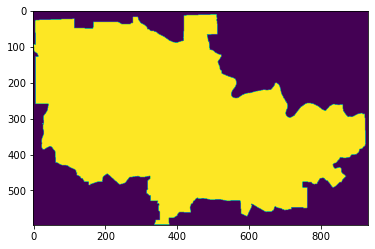

<AxesSubplot:>

In [74]:
show(np.dstack(msk))

In [76]:
msk.shape

(1, 596, 932)

In [92]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [101]:
outpath = r'T:\Models\StoryMap\UrbanSim'

In [102]:
fieldName = 'New Non-res SQFT'

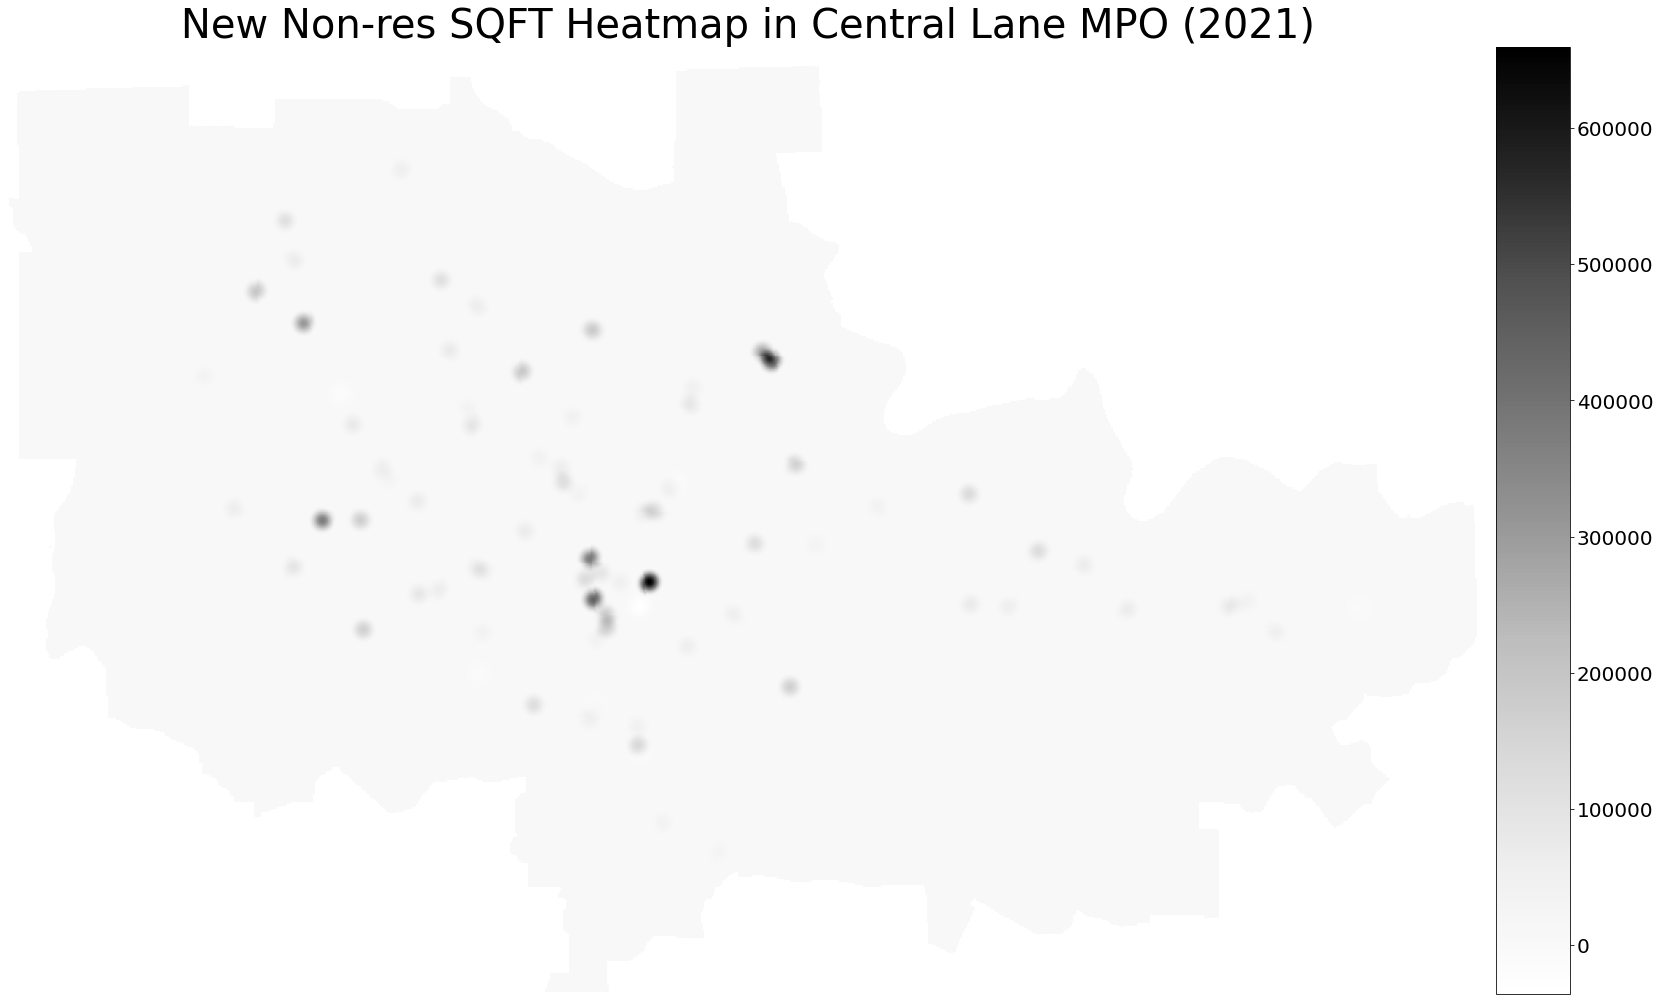

In [107]:
fig, ax = plt.subplots(figsize=(28, 24))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(src.read(1), 
                         cmap='Greys', 
                         vmin=-36000, 
                         vmax=660000)

# plot on the same axis with rio.plot.show
image = show(src.read(1), 
             #title = fieldName + " Heatmap in Central Lane MPO (" + str(yrbuilt) + ")",
             transform=src.transform, 
             ax=ax, 
             cmap='Greys', 
             vmin=-36000, 
             vmax=660000)

ax.set_title(fieldName + " Heatmap in Central Lane MPO (" + str(yrbuilt) + ")", fontsize=40)
# add colorbar using the now hidden image
cbar = fig.colorbar(image_hidden, ax=ax, cax=cax)
cbar.ax.tick_params(labelsize=20)
ax.axis("off");
plt.savefig(os.path.join(outpath, "heatmap_2021.png"), transparent=True, bbox_inches='tight')